In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from geotext import GeoText
import pycountry

from collections import Counter
from collections import defaultdict

In [2]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df=pop_df[['Country Code','2019']].dropna()
pop_df['2019']=pop_df['2019'].astype(int)
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values
possible_countries=[x.lower() for x in possible_countries]

In [17]:
df_country_list_different_spellings=pd.read_excel(r"C:\Users\Yasaman\Downloads\country_list_different_spellings_arabspring.xlsx")
df_country_list_different_spellings['ulke']=df_country_list_different_spellings['ulke'].apply(lambda x: x.lower())
map_country_list_different_spellings = pd.Series( df_country_list_different_spellings.ulke.values, index=df_country_list_different_spellings.yer).to_dict()
map_country_list_different_spellings['Turkey']='tur'

def get_country(txt):


    for copyright_mark in ['©', 'Copyright (C)']:
        if copyright_mark in txt:
            txt = txt.split(copyright_mark)[0]

    for tag in [ 'US dollar','New Mexico','Turkish','US$','US $','United States Dollar','USD','HK', 'Congo Red',
               'Congo red', 'US-Dollar', 'Michael Jordan','Guinea pig']:
        if tag in txt:
            txt=txt.replace(tag, '')

    places = GeoText(txt)
    country_codes = set()  # To store unique country codes.

    # Attempt to get country codes directly from GeoText results.
    for country_name in set(places.countries):
        country_code = pycountry.countries.get(name=country_name)
        if country_code:
            country_codes.add(country_code.alpha_3.lower())
        else:
            # Directly add to undefined list if not found.
            country_codes.add(map_country_list_different_spellings.get(country_name, country_name))

    pattern = r'\b(' + '|'.join(re.escape(country_name) for country_name in map_country_list_different_spellings.keys()) + r')\b'

    # Find all occurrences of country names in the text, considering word boundaries.
    matches = re.findall(pattern, txt)

    # For each matched country name, add its corresponding country code to the set.
    for match in matches:
        country_codes.add(map_country_list_different_spellings[match])


    # Handle special case for 'uae'.
    if 'uae' in country_codes:
        country_codes.remove('uae')
        country_codes.add('are')

    return list(country_codes)
df=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_arabspring_final.csv")
df['Text']=df['Title']+' '+df['Abstract']
df['Mentions']=df['Text'].apply(get_country)
def fractional_count_mentions_per_year(df):
    """
    Counts how many times each country is mentioned per year using fractional counting.

    Args:
        df (pd.DataFrame): DataFrame with 'Mentions' (list of countries) and 'Year' columns.

    Returns:
        pd.DataFrame: A DataFrame with each country, year, and their fractional mention counts.
    """
    mentions_by_year = defaultdict(float)

    # Iterate over rows to calculate fractional mentions by year
    for _, row in df.iterrows():
        year = row['Year']
        mentions = row['Mentions']
        weight = 1 / len(mentions) if mentions else 0  # Calculate fractional weight

        for country in mentions:
            mentions_by_year[(year, country)] += weight

    # Convert to DataFrame
    mention_counts_df = pd.DataFrame(
        [{'Year': year, 'Country': country, 'Mentions': count} 
         for (year, country), count in mentions_by_year.items()]
    )

    return mention_counts_df.sort_values(by=['Year', 'Country']).reset_index(drop=True)

result = fractional_count_mentions_per_year(df)
arabspring_countries=['egy', 'tun', 'lby', 'syr', 'mar', 'kwt', 'bhr', 'yem', 'omn', 'jor']
arab_results=result[result.Country.isin(arabspring_countries)]
Country_list = {'Egypt':'EGY', 'Tunisia':'TUN', 'Libya':'LBY', 'Syria':'SYR', 'Yemen':'YEM',
                    'Bahrain':'BHR', 'Jordan':'JOR', 'Kuwait':'KWT', 'Morocco':'MAR', 'Oman':'OMN'}
rev_Country_list = {Country_list[key].lower(): key for key in Country_list}
country_names = list(Country_list.keys())
custom_colors = [f'C{i}' for i in range(10)]

markers=['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']

arab_results['Country']=arab_results['Country'].map(rev_Country_list)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_22656\3570412578.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arab_results['Country']=arab_results['Country'].map(rev_Country_list)


In [18]:

# Calculate the proportion of rows where the 'Mentions' list has more than 0 elements
proportion = (df['Mentions'].apply(len) > 0).sum() / df.shape[0]
proportion

0.6784268363215732

In [19]:
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]

df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df=df[df['country'].isin(possible_countries)]
df=df.rename(columns={'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})
df=df[(df['year'].isin(np.arange(2002, 2020, 1)))&(df['Mention_country'].isin(abbr))]

physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df=df[~df['subjarea'].isin(physical_sciences)]

attention_df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()
attention_df['Mention_country']=attention_df['Mention_country'].apply(lambda x: x.upper())
attention_df['Country']=attention_df['Mention_country'].map(rev_Country_list)
attention_df=attention_df.rename(columns={'year':'Year', 'count':'total_attention'}).drop(columns=['Mention_country'])

In [20]:
total_df=attention_df.merge(arab_results, on=['Year', 'Country'], how='outer').fillna(0)
total_df['share']=total_df['Mentions']/total_df['total_attention']

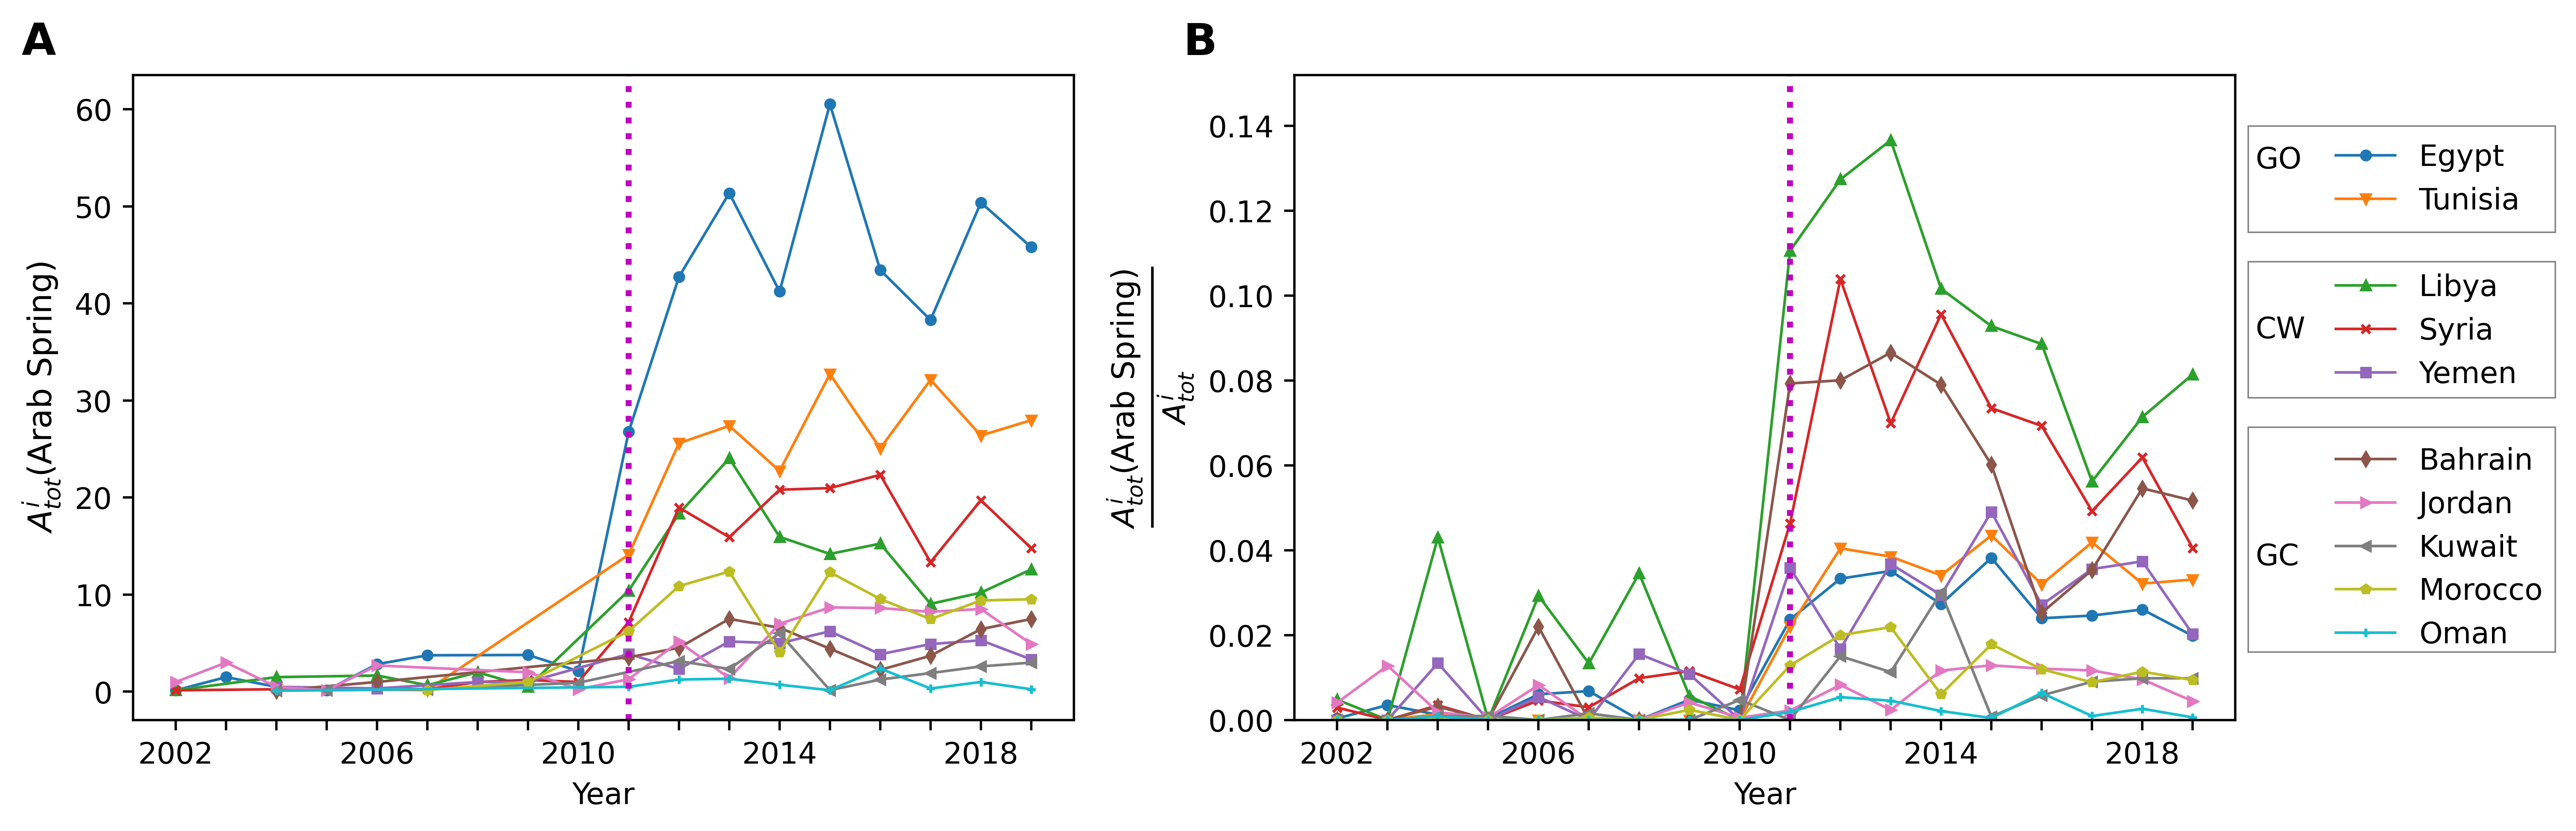

In [35]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(11, 4), dpi=500)
subplot_labels=['A', 'B', 'C', 'D']
ax=ax.flat
for i in range(2):
    t=ax[i].text(-0.1, 1.05, subplot_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='center', ha='center')
for i, c in enumerate(Country_list.keys()):
    subset=arab_results[arab_results['Country']==c]
    if i in [2, 5]:
        ax[0].plot(subset['Year'], subset['Mentions'],color='white', label=' ', linewidth=0.9, markersize=3)
    else:
        space=''
    ax[0].plot(subset['Year'], subset['Mentions'],color=custom_colors[i], marker=markers[i], label=c, linewidth=0.9, markersize=3)
ax[0].axvline(2011, color='m', linestyle=':', linewidth=2)

fig.legend( loc='upper right', frameon=False, ncol=1,bbox_to_anchor=(1.10, 0.85))

ax[0].set_xticks(range(2002, 2020))
ax[0].set_xticklabels([str(tick) if year % 4 == 0 else '' for year, tick in enumerate(range(2002, 2020))])
ax[0].set_xlabel('Year')
ax[0].set_ylabel(r'$A_{tot}^i (\text{Arab Spring})$', fontsize=11)




for i, c in enumerate(Country_list.keys()):
    subset=total_df[total_df['Country']==c]
    ax[1].plot(subset['Year'], subset['share'],color=custom_colors[i], marker=markers[i], label=c, linewidth=0.9, markersize=3)
ax[1].axvline(2011, color='m', linestyle=':', linewidth=2)
ax[1].set_xticks(range(2002, 2020))
ax[1].set_xticklabels([str(tick) if year % 4 == 0 else '' for year, tick in enumerate(range(2002, 2020))])
ax[1].set_xlabel('Year')
ax[1].set_ylim(0, 0.152)
ax[1].set_ylabel(r'$\frac{A_{tot}^i (\text{Arab Spring})}{A_{tot}^i}$', fontsize=15)

trans = ax[1].get_xaxis_transform()
    #ax[1].annotate('GO', xy=(1.1, ),transform=trans, annotation_clip=False)
ax[1].annotate('GC', xy=(2020.25, 0.0365),transform=trans, annotation_clip=False)
ax[1].annotate('CW', xy=(2020.25, 0.09),transform=trans, annotation_clip=False)
ax[1].annotate('GO', xy=(2020.25, 0.13),transform=trans, annotation_clip=False)

#ax[1].plot([2020, 2020],[0.01,0.03], color="k", transform=trans, clip_on=False)
    #ax[1].plot([2.5,5.75],[-0.39,-0.39], color="k", transform=trans, clip_on=False)
    #ax[1].plot([7,11.5],[-0.39,-0.39], color="k", transform=trans, clip_on=False)

fig.tight_layout()
import matplotlib
rect1 = matplotlib.patches.Rectangle(xy=(2020.1, 0.115),
                                    width=6.1, height=0.025
                                    ,
                                    linewidth=0.5, edgecolor='k',
                                    alpha = 0.5,
                                    facecolor='white', clip_on= False);


rect2 = matplotlib.patches.Rectangle(xy=(2020.1, 0.076),
                                    width=6.1, height=0.032
                                    ,
                                    linewidth=0.5, edgecolor='k',
                                    alpha = 0.5,
                                    facecolor='white', clip_on= False, zorder=1
                                    )

rect3 = matplotlib.patches.Rectangle(xy=(2020.1, 0.016),
                                    width=6.1, height=0.053
                                    ,
                                    linewidth=0.5, edgecolor='k',
                                    alpha = 0.5,
                                    facecolor='white', clip_on= False, zorder=1
                                    )
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)
fig.savefig('Figure7_A.pdf', bbox_extra_artists=(rect1,t), bbox_inches='tight')
